In [14]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
from DataCaller_Excel import DataCaller_Excel
from Model import Net
from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = True
BATCH_SIZE = 10
VAL_BATCH_SIZE = 10
LEARNING_RATE = 1e-3
EPOCHS = 50
PATIENCE = 20
VALIDATE_EVERY = 2
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64

cpu


In [15]:
#data path
BASE_PATH = 'small'
#TRAIN_PATH_IMG = os.path.join('images', BASE_PATH, 'train')
TRAIN_PATH_LABEL = os.path.join('data', BASE_PATH, 'traindata.xlsx')
#VAL_PATH_IMG = os.path.join('images', BASE_PATH, 'val')
VAL_PATH_LABEL = os.path.join('data', BASE_PATH, 'valdata.xlsx')
#TEST_PATH_IMG = os.path.join('images', BASE_PATH, 'test')
TEST_PATH_LABEL = os.path.join('data', BASE_PATH, 'testdata.xlsx')
LOAD_PRETRAINED_PATH = 'checkpoint.pt'

In [16]:
#load data
if LOAD_DATA:
    trainset = DataCaller_Excel(TRAIN_PATH_LABEL, IMG_SIZE)
    valset = DataCaller_Excel(VAL_PATH_LABEL, IMG_SIZE)
    testset = DataCaller_Excel(TEST_PATH_LABEL, IMG_SIZE)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

100
100
100


In [17]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

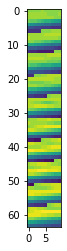

tensor([[16.0198, 12.6297, 10.4782,  8.7046,  3.9926],
        [14.1616, 18.4193, 11.7954,  4.7235,  3.4538],
        [13.1110, 19.2338,  5.6405,  3.5547,  4.6195],
        [14.0458, 14.4837,  5.1382, 11.0584,  3.5116],
        [17.7880, 14.2345,  1.6156,  3.7931,  1.6146],
        [16.9989, 16.3853,  0.5712,  1.1274,  2.2784],
        [17.7198, 19.3285, 17.2368,  3.7116,  1.5555],
        [19.5163, 19.2033,  1.0281, 14.1693,  2.0765],
        [16.5961, 15.1859, 16.1475,  9.8556,  4.2013],
        [16.2406, 16.7914,  6.4234,  6.1698,  4.9519]])


In [18]:
#just checking if the data is loaded properly
for i, data in enumerate(trainloader):
    x, y = data
    
    #print(x)
    x = np.array(x)
    x = x.reshape(IMG_SIZE, IMG_SIZE, -1)
    #print(x)
    x = x.astype(int)
    plt.imshow(x[0])
    plt.show()
    print(y)
    break

In [19]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    loss_function = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, 1, IMG_SIZE, IMG_SIZE)
                    
                    x = x.to(device)
                    y = y.to(device)
                    
                    net.zero_grad()
                    pred = net(x)
                    loss = loss_function(pred, y)
                    loss.backward()
                    optimizer.step()
                    
                    error = (pred - y) / y
                    error = error.mean(0)
                    train_losses.append(loss.item())
                    
                    #if idx%validate_every == 0:
                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)
                    
                    val_x = val_x.view(-1, 1, IMG_SIZE, IMG_SIZE)
                    val_pred = net(val_x)
                    val_loss = loss_function(val_pred, val_y)
                    val_error = (val_pred - val_y) / val_y
                    val_error = val_error.mean(0)
                    val_losses.append(val_loss.item())
                    
                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                
                train_losses = []
                val_losses = []
                
                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("batch : ", batch_idx)
                print("loss : ", train_loss, "\nval loss : ", valid_loss, "\n")
                #print("error : ", error, "\nval error : ", val_error)
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [20]:
net = Net()
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)

  2%|█▋                                                                                 | 1/50 [00:02<02:13,  2.72s/it]

batch :  9
loss :  105.89427375793457 
val loss :  105.9621795654297 

Validation loss decreased (inf --> 105.962180).  Saving model ...


  4%|███▎                                                                               | 2/50 [00:05<02:07,  2.65s/it]

batch :  9
loss :  49.64595947265625 
val loss :  99.01382141113281 

Validation loss decreased (105.962180 --> 99.013821).  Saving model ...


  6%|████▉                                                                              | 3/50 [00:07<02:04,  2.65s/it]

batch :  9
loss :  37.57563724517822 
val loss :  73.152787399292 

Validation loss decreased (99.013821 --> 73.152787).  Saving model ...


  8%|██████▋                                                                            | 4/50 [00:10<01:59,  2.59s/it]

batch :  9
loss :  32.510561561584474 
val loss :  35.23804893493652 

Validation loss decreased (73.152787 --> 35.238049).  Saving model ...


 10%|████████▎                                                                          | 5/50 [00:12<01:56,  2.59s/it]

batch :  9
loss :  23.39083251953125 
val loss :  32.196302032470705 

Validation loss decreased (35.238049 --> 32.196302).  Saving model ...


 12%|█████████▉                                                                         | 6/50 [00:15<01:53,  2.57s/it]

batch :  9
loss :  25.396437644958496 
val loss :  33.95616760253906 

EarlyStopping counter: 1 out of 20


 14%|███████████▌                                                                       | 7/50 [00:17<01:48,  2.53s/it]

batch :  9
loss :  27.15540466308594 
val loss :  21.127807807922363 

Validation loss decreased (32.196302 --> 21.127808).  Saving model ...


 16%|█████████████▎                                                                     | 8/50 [00:20<01:44,  2.48s/it]

batch :  9
loss :  20.97865581512451 
val loss :  20.84672107696533 

Validation loss decreased (21.127808 --> 20.846721).  Saving model ...


 18%|██████████████▉                                                                    | 9/50 [00:22<01:42,  2.51s/it]

batch :  9
loss :  22.944841194152833 
val loss :  15.088677787780762 

Validation loss decreased (20.846721 --> 15.088678).  Saving model ...


 20%|████████████████▍                                                                 | 10/50 [00:25<01:40,  2.52s/it]

batch :  9
loss :  19.692251014709473 
val loss :  28.225367736816406 

EarlyStopping counter: 1 out of 20


 22%|██████████████████                                                                | 11/50 [00:27<01:36,  2.48s/it]

batch :  9
loss :  20.213699054718017 
val loss :  23.819720840454103 

EarlyStopping counter: 2 out of 20


 24%|███████████████████▋                                                              | 12/50 [00:30<01:35,  2.51s/it]

batch :  9
loss :  16.54091520309448 
val loss :  25.699344062805174 

EarlyStopping counter: 3 out of 20


 26%|█████████████████████▎                                                            | 13/50 [00:33<01:35,  2.58s/it]

batch :  9
loss :  19.53842191696167 
val loss :  33.27014312744141 

EarlyStopping counter: 4 out of 20


 28%|██████████████████████▉                                                           | 14/50 [00:35<01:30,  2.52s/it]

batch :  9
loss :  20.29327154159546 
val loss :  32.68049621582031 

EarlyStopping counter: 5 out of 20


 30%|████████████████████████▌                                                         | 15/50 [00:38<01:30,  2.57s/it]

batch :  9
loss :  21.38974208831787 
val loss :  25.78270435333252 

EarlyStopping counter: 6 out of 20


 32%|██████████████████████████▏                                                       | 16/50 [00:40<01:27,  2.57s/it]

batch :  9
loss :  19.974290657043458 
val loss :  42.7078670501709 

EarlyStopping counter: 7 out of 20


 34%|███████████████████████████▉                                                      | 17/50 [00:43<01:23,  2.54s/it]

batch :  9
loss :  20.36698627471924 
val loss :  33.10667839050293 

EarlyStopping counter: 8 out of 20


 36%|█████████████████████████████▌                                                    | 18/50 [00:45<01:19,  2.48s/it]

batch :  9
loss :  22.15581407546997 
val loss :  18.253554153442384 

EarlyStopping counter: 9 out of 20


 38%|███████████████████████████████▏                                                  | 19/50 [00:48<01:17,  2.49s/it]

batch :  9
loss :  23.102673149108888 
val loss :  17.311777782440185 

EarlyStopping counter: 10 out of 20


 40%|████████████████████████████████▊                                                 | 20/50 [00:50<01:16,  2.56s/it]

batch :  9
loss :  19.013246631622316 
val loss :  16.192183208465575 

EarlyStopping counter: 11 out of 20


 42%|██████████████████████████████████▍                                               | 21/50 [00:53<01:14,  2.57s/it]

batch :  9
loss :  16.56972246170044 
val loss :  17.75982847213745 

EarlyStopping counter: 12 out of 20


KeyboardInterrupt: 

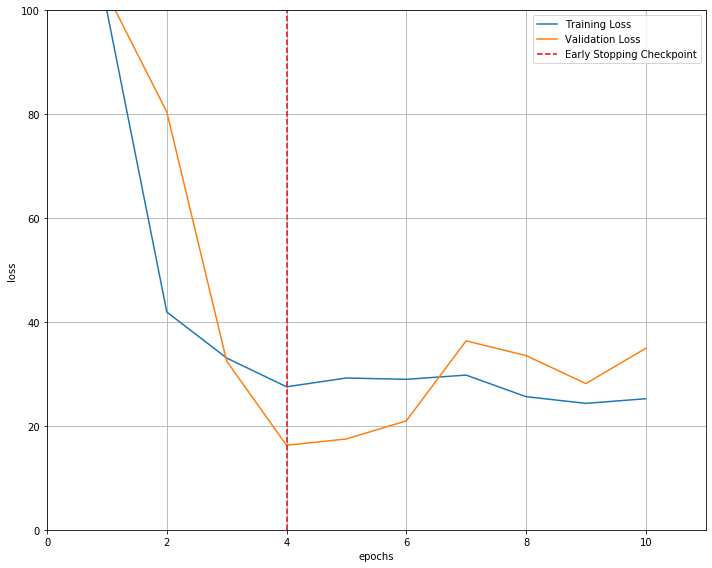

In [21]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [22]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            x ,y = sample
            x = x.view(-1, 1, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            predict = net(x)
            predict = np.array(predict)
            predictions.append(predict)
            
    #print(predictions)
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, 5)
    
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [23]:
trained_net = Net()
trained_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
trained_net.eval()
test(trained_net)